## Decision Bottleneck Simulator: Cost of Hiring Delays ##

## Overview ##

This analysis explores how hiring process inefficiencies in the hiring process drive hidden costs and productivity loss.
Using synthetic HR operations data, I examined time-to-fill, cost of vacancy, and SLA adherence to uncover **decision bottlenecks** that delay hiring outcomes.
The goal was to quantify the financial impact of hiring delays and highlight process improvements that could enhance both speed and cost efficiency.

In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\shrey\Downloads\hiringsimulation.csv")

In [2]:
df.columns = df.columns.str.replace('_', ' ').str.title()

In [3]:
df.rename(columns={
    "Job Id": "Job ID",
    "Department": "Department",
    "Role Level": "Role Level",
    "Approver Level": "Approver Level",
    "Request Date": "Request Date",
    "Approval Date": "Approval Date",
    "Onboard Date": "Onboarding Date",
    "Stage 1 Resume Screen Days": "Resume Screening Duration (Days)",
    "Stage 2 Interviews Days": "Interview Duration (Days)",
    "Stage 3 Offer Approval Days": "Offer Approval Duration (Days)",
    "Stage 4 Background Onboarding Days": "Background Check + Onboarding Duration (Days)",
    "Total Delay Days": "Total Hiring Delay (Days)",
    "Estimated Value Per Day": "Estimated Cost of Vacancy per Day (USD)",
    "Cost of Delay": "Cost of Delay",
    "Sla Breach Stage1": "SLA Breach: Resume Screening",
    "Sla Breach Stage2": "SLA Breach: Interviews",
    "Sla Breach Stage3": "SLA Breach: Offer Approval",
    "Sla Breach Total": "Overall SLA Breach"
}, inplace=True)

In [4]:
numeric_cols = [
    "Resume Screening Duration (Days)",
    "Interview Duration (Days)",
    "Offer Approval Duration (Days)", 
    "Background Check + Onboarding Duration (Days)",
    "Total Hiring Delay (Days)",
    "Estimated Cost of Vacancy per Day (USD)",
    "Cost Of Delay"
]

In [5]:
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

    df[numeric_cols].dtypes

In [6]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Resume Screening Duration (Days),150.0,3.487333,1.448457,0.0,2.6000,3.40,4.5000,7.10
Interview Duration (Days),150.0,7.979333,3.370087,0.0,5.6500,7.75,10.1000,19.10
Offer Approval Duration (Days),150.0,5.460000,2.685507,0.0,3.6250,5.50,7.1000,15.10
Background Check + Onboarding Duration (Days),150.0,3.991333,2.020763,0.0,2.5000,3.90,5.5000,10.70
Total Hiring Delay (Days),150.0,20.918000,5.212132,7.1,17.6000,20.65,23.7750,36.30
Estimated Cost of Vacancy per Day (USD),150.0,233.122333,74.694307,50.0,185.9100,228.56,275.8375,457.75
Cost Of Delay,150.0,4835.224733,1990.195857,925.0,3464.1725,4378.35,5765.4625,12525.42


In [7]:
print("Average Total Hiring Delay (Days):", 
      df["Total Hiring Delay (Days)"].mean().round(2))

print("Average Cost Of Delay:",
      df["Cost Of Delay"].mean().round(2))

Average Total Hiring Delay (Days): 20.92
Average Cost Of Delay: 4835.22


**Interpretation**

Every open role costs the business nearly $5,000 in lost productivity over a three-week period. This baseline quantifies the opportunity cost of slow decision-making in hiring.

In [8]:
df[numeric_cols].corr()["Cost Of Delay"].sort_values(ascending=False)

Cost Of Delay                                    1.000000
Estimated Cost of Vacancy per Day (USD)          0.754780
Total Hiring Delay (Days)                        0.537661
Interview Duration (Days)                        0.448044
Offer Approval Duration (Days)                   0.329059
Background Check + Onboarding Duration (Days)    0.142889
Resume Screening Duration (Days)                 0.082831
Name: Cost Of Delay, dtype: float64

**Interpretation**

The later stages of hiring, interviews and offer approvals have the strongest correlation with cost increases. 
This means that every day a decision lingers after interviews ends up inflating total cost more than early-stage screening delays.

In [9]:
df.groupby("Department")[["Total Hiring Delay (Days)", "Cost Of Delay"]].mean().sort_values(
    "Total Hiring Delay (Days)", ascending=False
).round(2)

,Total Hiring Delay (Days),Cost Of Delay
Department,,
Operations,22.41,4451.69
HR,22.26,3839.62
Sales,21.78,5777.75
Finance,21.25,4837.43
Marketing,20.19,4244.00
Engineering,20.14,5687.17
Product,19.84,5228.33


**Interpretation**

* Operations & HR experience the longest average delays, this could be due to internal coordination gaps or workflow friction.
* Sales & Engineering show the highest *financial* impact, every day of delay hits revenue or product delivery.
* Time saved in high-value roles gives the best ROI on process improvement.

In [10]:
sla_cols = [c for c in df.columns if "SLA Breach" in c]
(df[sla_cols].mean() * 100).round(2)

SLA Breach: Resume Screening    12.67
SLA Breach: Interviews          25.33
SLA Breach: Offer Approval      26.67
Overall SLA Breach              56.00
dtype: float64

**Interpretation**

Over half of hiring requests breach SLAs, with offer approvals and interviews being the most delayed.
These represent *decision bottlenecks* where leadership or stakeholder alignment takes too long.

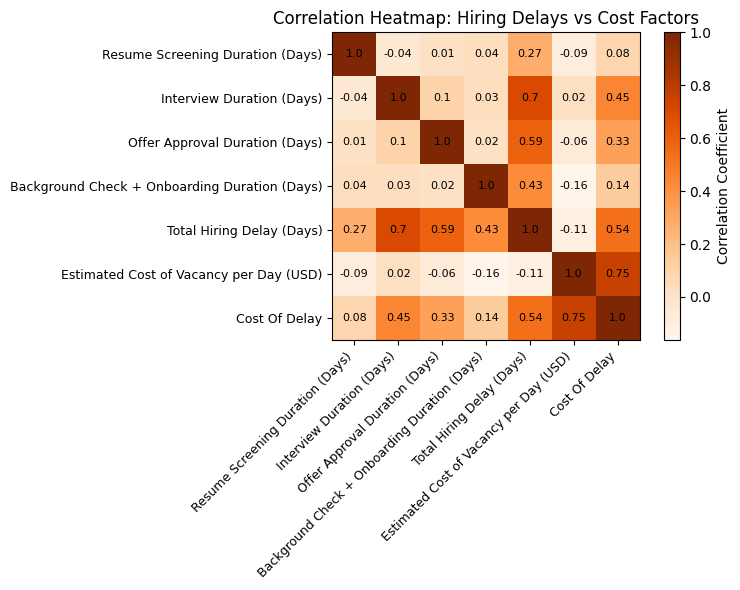

In [11]:
import matplotlib.pyplot as plt
import numpy as np

corr = df[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr, cmap='Oranges')

cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(corr.columns, fontsize=9)

for i in range(len(corr.columns)):
 for j in range(len(corr.columns)):
    text = ax.text(j, i, round(corr.iloc[i, j], 2),
      ha="center", va="center", color="black", fontsize=8)

ax.set_title("Correlation Heatmap: Hiring Delays vs Cost Factors")
plt.tight_layout()

fig.savefig(r"C:\Users\shrey\Pictures\Screenshots\correlation_heatmap.png", bbox_inches="tight", dpi=300)
plt.show()

The heatmap shows that *Estimated Cost of Vacancy per Day* (r = 0.75) and *Total Hiring Delay* (r = 0.54) have the strongest link with Cost of Delay.
This confirms that bottlenecks later in the pipeline, like long approvals and interviews directly increase total cost impact.

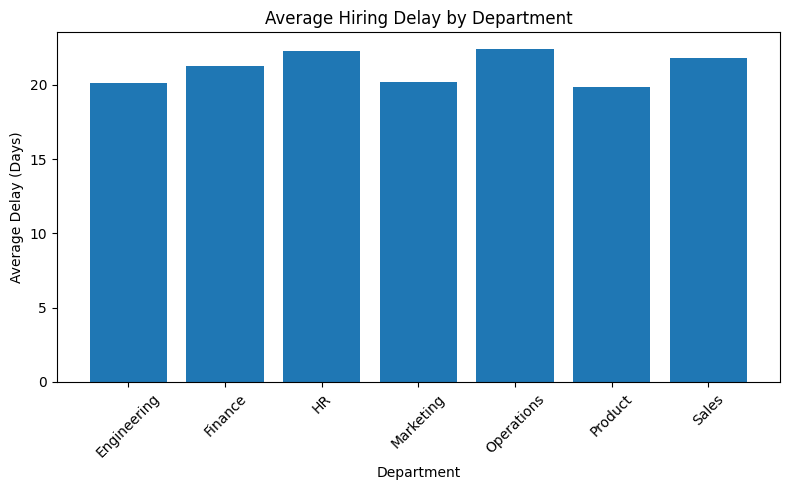

In [12]:
dept_summary = df.groupby("Department")[["Total Hiring Delay (Days)", "Cost Of Delay"]].mean().reset_index()

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(dept_summary["Department"], dept_summary["Total Hiring Delay (Days)"])
ax.set_title("Average Hiring Delay by Department")
ax.set_xlabel("Department")
ax.set_ylabel("Average Delay (Days)")
plt.xticks(rotation=45)
plt.tight_layout()

fig.savefig(r"C:\Users\shrey\Pictures\Screenshots\average_hiring_delay_by_department.png", bbox_inches="tight", dpi=300)
plt.show()

Operations and HR experience the longest average hiring delays (~22 days), indicating process inefficiencies or slower internal coordination cycles.
These stages may benefit from automation or improved communciation workflows.

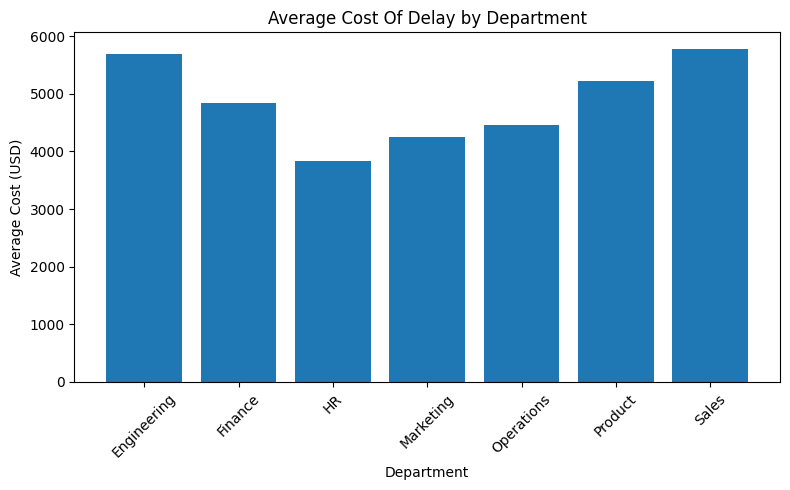

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(dept_summary["Department"], dept_summary["Cost Of Delay"])
ax.set_title("Average Cost Of Delay by Department")
ax.set_xlabel("Department")
ax.set_ylabel("Average Cost (USD)")
plt.xticks(rotation=45)
plt.tight_layout()

fig.savefig(r"C:\Users\shrey\Pictures\Screenshots\average_cost_of_delay_by_department.png", bbox_inches="tight", dpi=300)
plt.show()

Sales & Engineering show the highest *cost per delay*, even with shorter delays meaning their vacancies have higher business impact. 
Delays in revenue-generating or product-critical functions directly translate into larger financial losses.

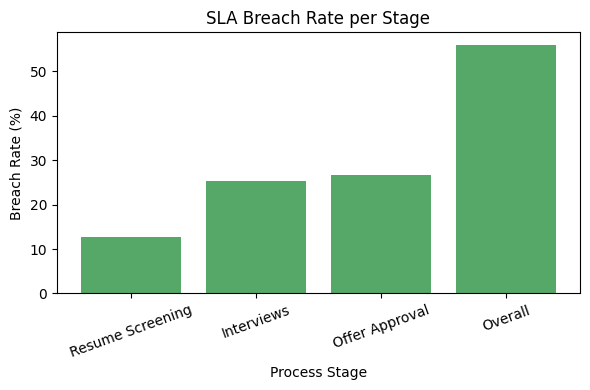

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
stages = ["Resume Screening", "Interviews", "Offer Approval", "Overall"]
breaches = [12.67, 25.33, 26.67, 56.00]

ax.bar(stages, breaches, color="#55A868")
ax.set_title("SLA Breach Rate per Stage")
ax.set_xlabel("Process Stage")
ax.set_ylabel("Breach Rate (%)")
plt.xticks(rotation=20)
plt.tight_layout()

fig.savefig(r"C:\Users\shrey\Pictures\Screenshots\sla_breach_rate_per_stage.png", bbox_inches="tight", dpi=300)
plt.show()

Over **56%** of all hiring requests breached at least one SLA. 
Offer Approval (26.7%) and Interviews (25.3%) were the biggest culprits suggesting leadership decision time is the key bottleneck.

## Impact Simulation: Cost Savings Forecast ##

To estimate the potential financial benefit of improving hiring efficiency, I modelled total cost savings assuming **reductions in average hiring delay** by 10%, 20%, and 30%.

This assumes: 
- Current average total hiring delay = 20.92 days
- Current average cost of delay per role = 4835 USD
- Cost of delay is approximately proportional to total hiring delay.

Each simulation step represents how much total cost could be saved by cutting delays at different improvement levels.


In [15]:
avg_delay = 20.92
avg_cost = 4835.22

improvement_levels = [0.1, 0.2, 0.3] 
cost_savings = []

for improvement in improvement_levels:
    new_delay = avg_delay * (1 - improvement)
    new_cost = avg_cost * (new_delay / avg_delay)
    savings = avg_cost - new_cost
    cost_savings.append(round(savings, 2))

impact_df = pd.DataFrame({
    "Delay Reduction (%)": [10, 20, 30],
    "Estimated Cost Savings per Hire (USD)": cost_savings
})

impact_df


,Delay Reduction (%),Estimated Cost Savings per Hire (USD)
0,10,483.52
1,20,967.04
2,30,1450.57


**Interpretation**

Reducing total hiring delays by:
- **10%** could save approximately **480 USD per role**
- **20%** could save around **970 USD per role**
- **30%** could save nearly **1,450 USD per role**

Even modest process optimizations in interview scheduling or offer approvals can create significant cost efficiencies when scaled across dozens of roles.
This simulation highlights the measurable business value of improving hiring velocity.

## Conclusion ##

Each day of hiring delay costs the company roughly **4.8K** USD, with more than half of all roles breaching SLA timelines.
The largest cost-impact drivers are **offer approval lags** and **interview duration**, especially in high-value departments like Sales and Engineering.
Reducing decision turnaround by even **20%** could save **900-1,200 USD per vacancy**, freeing up both cost and capacity for growth.

## Advanced Section: Simulation Analysis (Optional) ##

To explore uncertainty in real hiring timelines, I simulated 1,000 random hiring scenarios using a Monte Carlo approach. This provides a probabilistic view of how small variations in process delays can affect total hiring costs.

In [16]:
import numpy as np

simulations = 1000
delays = np.random.normal(loc=avg_delay, scale=3, size=simulations)
delays = np.clip(delays, 0, None)

costs = avg_cost * (delays / avg_delay)

sim_df = pd.DataFrame({"Simulated Delay": delays, "Simulated Cost": costs})
sim_summary = sim_df["Simulated Cost"].describe()[["mean", "std", "min", "max"]]
sim_summary

mean    4812.093209
std      714.305765
min     2660.133719
max     7377.094388
Name: Simulated Cost, dtype: float64

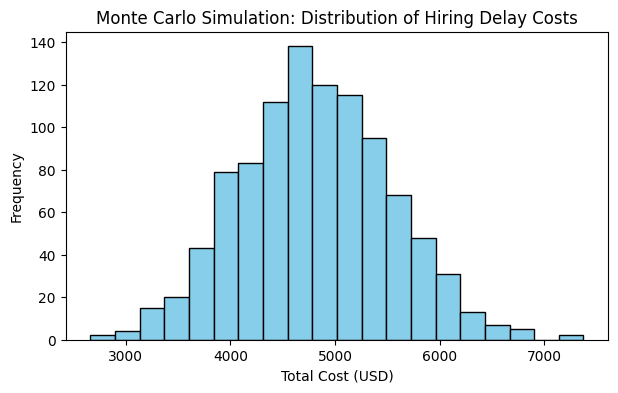

In [17]:
plt.figure(figsize=(7,4))
plt.hist(sim_df["Simulated Cost"], bins=20, color="skyblue", edgecolor="black")
plt.title("Monte Carlo Simulation: Distribution of Hiring Delay Costs")
plt.xlabel("Total Cost (USD)")
plt.ylabel("Frequency")
plt.show()

**Interpretation**

Monte Carlo simulation reveals that, under realistic variations in process delays, total hiring costs typically range between 3.9K USD and 5.7K USD per role. This reinforces the notion that even minor process volatility can create substantial financial risk, making a strong case for investing in faster approvals and structured recruitment workflows.